## Import Libraries

In [1]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Simple Exponential Smoothing models
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

## Data preprocessing

### Read data

In [2]:
df = pd.read_csv('ABBV-AbbVie.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,79.769997,80.849998,79.279999,80.099998,62.999912,8567900
1,2019-03-04,80.400002,80.730003,79.110001,79.459999,62.496529,5872500
2,2019-03-05,79.379997,79.900002,78.720001,78.910004,62.063969,5933100
3,2019-03-06,79.129997,79.129997,77.559998,78.089996,61.419025,5293200
4,2019-03-07,77.769997,79.120003,77.440002,78.239998,61.537003,6642500
...,...,...,...,...,...,...,...
1254,2024-02-23,177.259995,178.910004,177.009995,178.089996,176.442200,3941800
1255,2024-02-26,178.839996,179.789993,178.000000,178.809998,177.155533,4327400
1256,2024-02-27,178.770004,179.529999,176.979996,178.990005,177.333878,3888500
1257,2024-02-28,179.850006,179.889999,176.889999,178.000000,176.353043,4331300


### Reset index

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [4]:
# Select column 'Close'
df_Close = df[['Close']]

### Data normalization

In [5]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [6]:
# Split the data into training, validation and test dataset in a ratio of 7:1:2
train_size = int(0.7 * len(data_scaled))
val_size = int(0.1 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [7]:
best_alpha = None
best_mse = float('inf')
best_rmse = None
best_mape = None
best_msle = None
best_y_pred_val = None

### Training process

In [8]:
for alpha in np.arange(0.1, 1, 0.1):
    alpha = round(alpha, 1)
    history = train_data.copy()  # Use a copy of the training data
    y_pred_val = []

    for i in val_data:
        model = SimpleExpSmoothing(history)
        model_fit = model.fit(smoothing_level=alpha, optimized=False)  # Suppress EstimationWarnings
        prediction = model_fit.forecast()
        y_pred_val.append(prediction[0])
        history = np.append(history, i)

    val_data_temp = val_data
    val_data_temp = scaler.inverse_transform(val_data_temp)
    y_pred_val = scaler.inverse_transform(np.array([y_pred_val]).reshape(-1, 1))

    mape = mean_absolute_percentage_error(val_data_temp, y_pred_val)
    mse = mean_squared_error(val_data_temp, y_pred_val)
    rmse = np.sqrt(mse)
    msle = mean_squared_log_error(val_data_temp, y_pred_val)

    if mse < best_mse:
        best_alpha = alpha
        best_mse = mse
        best_rmse = rmse
        best_mape = mape
        best_msle = msle
        best_y_pred_val = y_pred_val

In [9]:
print(f"Best alpha: ", best_alpha)

Best alpha:  0.9


In [10]:
print(f"MAPE on Validate dataset: ", best_mape)
print(f"RMSE on Validate dataset: ", best_rmse)
print(f"MSLE on Validate dataset: ", best_msle)

MAPE on Validate dataset:  0.010766639949129438
RMSE on Validate dataset:  2.1017422052509773
MSLE on Validate dataset:  0.00020051029345584902


### Testing process

In [11]:
y_pred = []

for i in test_data:
    model = SimpleExpSmoothing(history)
    model_fit = model.fit(smoothing_level=best_alpha, optimized=False)  # Suppress EstimationWarnings
    prediction = model_fit.forecast()
    y_pred.append(prediction[0])
    history = np.append(history, i)


In [12]:
# Evaluate the accuracy of test
test_data = scaler.inverse_transform(test_data)
y_pred = scaler.inverse_transform(np.array([y_pred]).reshape(-1, 1))

test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_mse = mean_squared_error(test_data, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(test_data, y_pred)

print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)

MAPE on Test dataset:  0.00845101433123905
RMSE on Test dataset:  1.8171412247906338
MSLE on Test dataset:  0.00014522298150648728


## Predicting the next 30 days

### Preparing the forecast date index

In [13]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

### Prediction process

In [14]:
# Predict the closing prices for the next 30 days
y_next_30_days = []

for i in range(30):
  model = SimpleExpSmoothing(history)
  model_fit = model.fit(smoothing_level = best_alpha, optimized=False)
  prediction = model_fit.forecast()
  y_next_30_days.append(prediction[0])
  history = np.append(history, prediction[0])

# Print the predicted closing prices for the next 30 days
y_next_30_days = scaler.inverse_transform(np.array([y_next_30_days]).reshape(-1, 1))
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days.flatten())

Predicted closing prices for the next 30 days:
[176.25463581 176.25463581 176.25463581 176.25463581 176.25463581
 176.25463581 176.25463581 176.25463581 176.25463581 176.25463581
 176.25463581 176.25463581 176.25463581 176.25463581 176.25463581
 176.25463581 176.25463581 176.25463581 176.25463581 176.25463581
 176.25463581 176.25463581 176.25463581 176.25463581 176.25463581
 176.25463581 176.25463581 176.25463581 176.25463581 176.25463581]


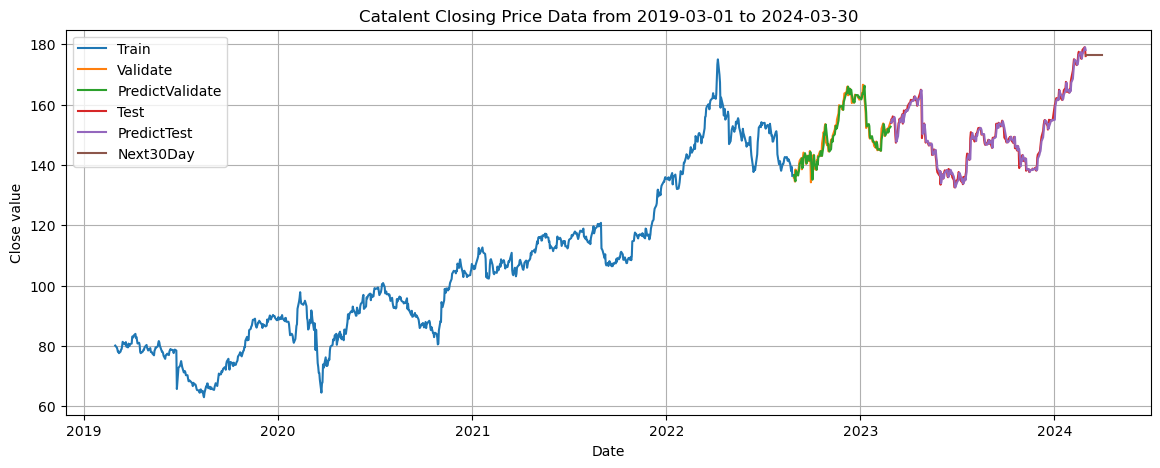

In [15]:
# Drawing
plt.figure(figsize=(14, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(np.array([train_data]).reshape(-1, 1)).flatten())

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(np.array([val_data]).reshape(-1, 1)).flatten())

plt.plot(df.index[train_size : train_size + val_size], best_y_pred_val)

plt.plot(df.index[train_size + val_size :], test_data)

plt.plot(df.index[train_size + val_size :], y_pred)

plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'PredictValidate', 'Test', 'PredictTest', 'Next30Day'])

plt.grid()
plt.title(f"Catalent Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('image/ETS_712_30day_ABBV.png')
plt.show()